<a href="https://colab.research.google.com/github/kevinkevin556/Dlchemist/blob/main/vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **VGG**

# **Section 1. Set up**

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import drive

# Mount your google drive to save training checkpoints.

drive.mount('/content/gdrive')

# Prepare directory for PATH.

for folder in ["VGG7", "VGG11", "VGG16"]:
  directory = f"/content/gdrive/MyDrive/Colab Checkpoints/{folder}/"
  if not os.path.exists(directory):
      os.makedirs(directory)

Mounted at /content/gdrive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch import tensor
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### *Dataset and DataLoader*


In [ ]:
from torchvision.datasets import ImageFolder
from fastai.vision.all import URLs, untar_data

root = untar_data(URLs.IMAGENETTE)
print("Root directory:", root)

train_dataset = ImageFolder(str(root)+"/train")

# Generate indices to permute the training data and conduct train-test-split
total_size = len(train_dataset)
valid_size = total_size // 5
rng = np.random.default_rng(42)
indices = rng.permutation(total_size)

Root directory: /root/.fastai/data/imagenette2


In [ ]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Get mean RGB value, computed on the training set
train_dataset = ImageFolder(str(root)+"/train", transform=ToTensor())
train_dataset = Subset(train_dataset, indices[:-valid_size])
train_dataloader = DataLoader(train_dataset, batch_size=1)

# sum = torch.zeros(3)
# for data, _ in train_dataloader:
#   sum = sum + data.mean(axis=(0, 2, 3))
# mean = sum / len(train_dataloader)

mean = torch.tensor([0.4631, 0.4591, 0.4305])
print("Mean:", mean)

Mean: tensor([0.4631, 0.4591, 0.4305])


In [ ]:
from torchvision.transforms import (
    Compose, RandomCrop, RandomHorizontalFlip,
    Resize, ColorJitter, Normalize
)

S = 256   # Training scale
Q = 256   # Testing scale

normalize = Normalize(mean, [1., 1., 1.])

## Training Set

train_tfms = Compose([
    ToTensor(),
    normalize,                      # Subtract the mean RGB value
    Resize(S),                      # Isotropically rescale images to S
    RandomCrop(224),                # Crop images to fixed-size 224 x 224
    RandomHorizontalFlip(p=0.5),    # Augmentation: random horizontal flipping
    # ColorJitter(0.2, 0.2, 0.2),     # Augmentation: random RGB color shift
])

train_dataset = ImageFolder(str(root)+"/train", transform=train_tfms)
train_dataset = Subset(train_dataset, indices[:-valid_size])


## Validation Set and Testing Set

test_tfms = Compose([ToTensor(), normalize, Resize(Q)])
flip_tfms = Compose([test_tfms, RandomHorizontalFlip(p=1)])

valid_dataset = ImageFolder(str(root)+"/train", transform=test_tfms)
valid_dataset = Subset(valid_dataset, indices[-valid_size:])

valid_dataset_f = ImageFolder(str(root)+"/train", transform=flip_tfms)
valid_dataset_f = Subset(valid_dataset_f, indices[-valid_size:])

test_dataset = ImageFolder(str(root)+"/val", transform=test_tfms)
test_dataset_f = ImageFolder(str(root)+"/val", transform=flip_tfms)


print("\nData Size:")
print("* Training set   => ", len(train_dataset), "images")
print("* Validation set => ", len(valid_dataset), "images")
print("* Testing set    => ", len(test_dataset), "images")

print("\nImage Shape (C, H, W):")
print("* Training image:", train_dataset[0][0].shape)
print("* Testing image: ", test_dataset[0][0].shape)


Data Size:
* Training set   =>  7576 images
* Validation set =>  1893 images
* Testing set    =>  3925 images

Image Shape (C, H, W):
* Training image: torch.Size([3, 224, 224])
* Testing image:  torch.Size([3, 256, 341])


In [ ]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=False, pin_memory=True)
valid_dataloader_f = DataLoader(valid_dataset_f, batch_size=1, shuffle=False, pin_memory=True)

test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True)
test_dataloader_f = DataLoader(test_dataset_f, batch_size=1, shuffle=False, pin_memory=True)

### *HyperModule*

[FC to Conv](https://cs231n.github.io/convolutional-networks/#convert)

In [ ]:
from einops import rearrange, reduce
from torch.nn import (
    Conv2d, ReLU, MaxPool2d, Sequential,
    Flatten, Linear, Softmax, AvgPool2d,
    Dropout
)

class VGG(nn.Module):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv_net = None
    self.fc = None
    self.converted_conv = None

  def forward(self, x):
    if self.train_state:
      return self.net(x)
    else: 
      return reduce(self.net(x), "N C H W -> N C", "sum")

  def train(self, mode=True):
    super().train(mode)
    self.train_state = mode
    self.net = self.build_net(mode)
    return self

  def build_net(self, training_mode):
    if training_mode:
      return Sequential(self.conv_net, self.fc)
    else:
      self.copy_weights()
      return Sequential(self.conv_net, self.converted_conv)

  def copy_weights(self):
    linear_index = [i for i in range(len(self.fc)) 
                            if type(self.fc[i]) == Linear]
    conv_index = [j for j in range(len(self.converted_conv)) 
                          if type(self.converted_conv[j]) == Conv2d]

    for k in range(len(linear_index)):
      N, C, H, W = self.converted_conv[conv_index[k]].weight.shape

      weight = self.fc[linear_index[k]].weight
      weight = rearrange(weight, "N (C H W) -> N C H W", H=H, W=W)
      self.converted_conv[conv_index[k]].weight = torch.nn.Parameter(weight)
     
      bias = torch.nn.Parameter(self.fc[linear_index[k]].bias)
      self.converted_conv[conv_index[k]].bias = bias

  def __repr__(self):
    return self.net.__repr__()

In [ ]:
import sklearn.metrics
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class HyperModule():
    def __init__(self, model, criterion, optimizer, scheduler=None, load_path=None):
        if load_path is None:
            self.model, self.criterion, self.optimizer = model, criterion, optimizer
            self.scheduler = scheduler
            self.epoch_trained = 0
            self.train_loss = []
            self.valid_acc = []
            self.test_acc = None
        else:
            self.load(load_path)


    def train(self, train_dataloader, valid_dataloader=(None, None),
              save_path=None, num_epochs=1):
        device = torch.device('cuda')
        self.model.to(device)
        best_acc = 0 if len(self.valid_acc)==0 else max(self.valid_acc) 
        start_epoch = self.epoch_trained
        self.model.train()

        for epoch in range(num_epochs):
            
            self.batch_loss, self.batch_acc = [], []
            self.epoch_trained += 1

            ## Training stage
            train_progress = tqdm(train_dataloader, position=0, leave=True)
            for images, targets in train_progress:
                images, targets = images.to(device), targets.to(device)
                self.update_(images, targets)
                self.update_prog_(train_progress, start_epoch+num_epochs)
            
            batch_avg_loss = np.mean(self.batch_loss)
            
            ## Validation stage (or choose not to validate)
            if None in valid_dataloader or valid_dataloader is None:
              self.batch_acc = [np.nan]
              self.update_schd_(batch_avg_loss) # Update scheduler based on training loss
              print(f"Train Loss: {batch_avg_loss:.3f}, Valid Acc: --- No Validation ---")
            else:
              self.batch_acc = self.validate(*valid_dataloader)
              batch_avg_acc = np.mean(self.batch_acc)
              self.update_schd_(batch_avg_acc)  # Update scheduler based on validation accuracy
              print(f"Train Loss: {batch_avg_loss:.3f}, Valid Acc:{batch_avg_acc:.3f}")
            
            self.update_hist_() # Update training loss and validation acc.
            self.model.train()  # Switch to training mode to save the arch. w/ FC.

            ## Save the best model (if any)
            if np.mean(self.batch_acc) > best_acc:  
                best_acc = np.mean(self.batch_acc)
                self.save(save_path)

        # Save the model trained in the last epoch (if validation)
        if not (None in valid_dataloader or valid_dataloader is None):
            self.save(save_path+".final")
            
        self.batch_loss, self.batch_acc = [], []
        self.test_acc = None
        

    def validate(self, dataloader, dataloader_f):
        device = torch.device('cuda')
        self.model.eval()
        batch_acc = []
        with torch.no_grad():
            for (images, targets), (images_f, targets_f) in zip(dataloader, dataloader_f):
                images, targets = images.to(device), targets.to(device)
                images_f, targets_f = images_f.to(device), targets_f.to(device)
                preds, preds_f = self.model(images), self.model(images_f)

                # The soft-max class posteriors of the original and flipped images 
                #     are averaged to obtain the final scores for the image.
                pred_labels = torch.argmax(preds + preds_f, dim=1)
                batch_acc.append((pred_labels == targets).type(torch.float32).mean().item())
        return batch_acc


    def test(self, dataloader, dataloader_f, load_path=None, confusion_matrix=True, class_names=None):
        device = torch.device('cuda')
        np_pred_labels, np_targets = [], [] 
        if load_path is not None:
            self.load(load_path)
        self.model.to(device)
        self.model.eval()

        # Obtain predictions and ground truths
        with torch.no_grad():
            for (images, targets), (images_f, targets_f) in zip(dataloader, dataloader_f):
                images, targets = images.to(device), targets.to(device)
                images_f, targets_f = images_f.to(device), targets_f.to(device)
                pred_labels, targets = self.get_prediction_(images, images_f, targets)
                np_pred_labels.append(pred_labels)
                np_targets.append(targets)

        np_pred_labels = np.concatenate(np_pred_labels)
        np_targets = np.concatenate(np_targets)

        if confusion_matrix:
            conf_mat = sklearn.metrics.confusion_matrix(np_targets, np_pred_labels)
            conf_df = self.generate_confusion_df_(conf_mat, class_names)
            self.plot_confusion_matrix_(conf_df)
            self.print_class_acc_(conf_df)
        
        ## print total accuracy
        self.test_acc = np.mean(np_targets == np_pred_labels)
        print("\nTotal Acc:", np.mean(np_targets == np_pred_labels))

                
    def load(self, path):
        device = torch.device('cuda')
        state_dict = torch.load(path)
        
        self.model.load_state_dict(state_dict["model"])
        self.model.to(device)
        
        self.optimizer.load_state_dict(state_dict["optimizer"])
        self.scheduler.load_state_dict(state_dict["scheduler"])
        self.test_acc = state_dict["test_acc"]

        n_train_loss = len(state_dict["train_loss"])
        n_valid_acc = len(state_dict["valid_acc"])
        epoch_trained = state_dict["epoch_trained"]
        n = min(epoch_trained, n_train_loss, n_valid_acc)

        self.epoch_trained = n
        self.train_loss = state_dict["train_loss"][:n]
        self.valid_acc = state_dict["valid_acc"][:n]
        print("State dict sucessfully loaded.")


    def save(self, path):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        torch.save(state_dict, path)
        print("State dict saved.")
    

    def get_state_dict(self):
        state_dict = {}
        state_dict["model"] = self.model.state_dict()
        state_dict["optimizer"] = self.optimizer.state_dict()
        state_dict["scheduler"] = self.scheduler.state_dict()
        state_dict["epoch_trained"] = self.epoch_trained
        state_dict["train_loss"] = self.train_loss
        state_dict["valid_acc"] = self.valid_acc
        state_dict["test_acc"] = self.test_acc
        return state_dict

    #--------------------------------------------------------------------------#

    ### Auxilary functions in test()
     
    def get_prediction_(self, images, images_f, targets):
        preds, preds_f = self.model(images), self.model(images_f)

        # The soft-max class posteriors of the original and flipped images 
        #     are averaged to obtain the final scores for the image.
        pred_labels = torch.argmax(preds + preds_f, dim=1)
        pred_labels = pred_labels.view(-1).detach().cpu().numpy()
        targets = targets.view(-1).detach().cpu().numpy()
        return pred_labels, targets

    def generate_confusion_df_(self, conf_mat, class_names):
        if class_names is not None:
            conf_df = pd.DataFrame(conf_mat, class_names, class_names)
        else:
            conf_df = pd.DataFrame(conf_mat)
        return conf_df
        
    def plot_confusion_matrix_(self, conf_df):
        plt.figure(figsize = (12,8))
        sns.heatmap(conf_df, annot=True, fmt="d", cmap='Blues')
        plt.xlabel("prediction")
        plt.ylabel("label (ground truth)")
        plt.show()

    def print_class_acc_(self, conf_df):
        for i in range(len(conf_df)):
            total = np.sum(conf_df.iloc[i, :])
            correct = conf_df.iloc[i, i]
            print(f"Acc of {conf_df.columns[i]}: {correct/total:.4f}")

    
    ### Auxilary functions in train()
    
    def update_(self, images, targets):
        preds = self.model(images)
        loss = self.criterion(preds, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.batch_loss.append(loss.detach().item())

    def update_prog_(self, progress, num_epochs):
        loss = self.batch_loss[-1]
        epoch = self.epoch_trained
        progress.set_description(f'Epoch [{epoch}/{num_epochs}]')
        progress.set_postfix({'loss': loss})

    def update_schd_(self, val_acc):
        if self.scheduler is not None:
            self.scheduler.step(val_acc)

    def update_hist_(self):
        self.train_loss.append(np.mean(self.batch_loss))
        self.valid_acc.append(np.mean(self.batch_acc))

### *Network Architecture*

<img src="https://miro.medium.com/max/1100/1*V6hPq-srR86AIWYrgFYLfA.webp" alt="drawing" width="500" height="300"/>



In [ ]:
class VGG16(VGG):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv_net = Sequential(
        Conv2d(3, 64, kernel_size=3, stride=1, padding=1),       ReLU(),
        Conv2d(64, 64, kernel_size=3, stride=1, padding=1),      ReLU(),
        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(64, 128, kernel_size=3, stride=1, padding=1),     ReLU(),
        Conv2d(128, 128, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(128, 256, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(256, 256, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(256, 256, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(256, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),

        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = Sequential(
        Flatten(),
        Linear(512*7*7, 4096),                                   ReLU(),
        Dropout(0.5),
        Linear(4096, 4096),                                      ReLU(),
        Dropout(0.5),
        Linear(4096, num_classes)
    )
    self.converted_conv = Sequential(
        Conv2d(512, 4096, kernel_size=7, stride=1),              ReLU(),
        Conv2d(4096, 4096, kernel_size=1, stride=1),             ReLU(),
        Conv2d(4096, num_classes, kernel_size=1, stride=1),      Softmax(dim=1),
    )
    self.train_state = True
    self.net = self.build_net(self.train_state)

In [ ]:
#@title Check Forward Path: Training
X = torch.randn(1, *train_dataset[0][0].shape)
model = VGG16()
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in model.net:
    X = layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")
del model

Image shape:              [1, 3, 224, 224]
Sequential output shape:  [1, 512, 7, 7]
Sequential output shape:  [1, 10]


In [ ]:
#@title Check Forward Path: Testing
X = torch.randn(1, *test_dataset[2][0].shape)
model = VGG16()
model.eval()
print(f"{'Image shape:':25s} {list(X.shape)}")
for layer in model.net:
    X = layer(X)
    print(f"{layer.__class__.__name__+' output shape:':25s} {list(X.shape)}")

X = torch.randn(1, *train_dataset[0][0].shape)
print(f"{'Final outout shape:':25s} {list(model(X).shape)}")
del model

Image shape:              [1, 3, 256, 341]
Sequential output shape:  [1, 512, 8, 10]
Sequential output shape:  [1, 10, 2, 4]
Final outout shape:       [1, 10]


In [ ]:
#@title Check FC to Convolution Conversion
model = VGG16()
dataloader = DataLoader(train_dataset, batch_size=5, shuffle=False)
image, target = next(iter(dataloader))

model.train()
softmax = nn.Softmax(dim=1)
print("FC with softmax activation:\n", softmax(model(image)))

model.eval()
print("\nConv with softmax activation:\n", model(image))

del model

FC with softmax activation:
 tensor([[0.1018, 0.1018, 0.1009, 0.1008, 0.0994, 0.0985, 0.0983, 0.0991, 0.1007,
         0.0986],
        [0.1014, 0.1015, 0.1009, 0.1009, 0.0994, 0.0982, 0.0986, 0.0998, 0.1011,
         0.0982],
        [0.1016, 0.1017, 0.1007, 0.1009, 0.0991, 0.0985, 0.0994, 0.0993, 0.1003,
         0.0985],
        [0.1009, 0.1014, 0.1005, 0.1008, 0.0996, 0.0985, 0.0987, 0.0996, 0.1012,
         0.0987],
        [0.1015, 0.1011, 0.1013, 0.1007, 0.0993, 0.0986, 0.0986, 0.0996, 0.1013,
         0.0982]], grad_fn=<SoftmaxBackward0>)

Conv with softmax activation:
 tensor([[0.1011, 0.1011, 0.1010, 0.1011, 0.0994, 0.0987, 0.0985, 0.0996, 0.1008,
         0.0986],
        [0.1011, 0.1011, 0.1010, 0.1011, 0.0994, 0.0987, 0.0985, 0.0996, 0.1008,
         0.0986],
        [0.1011, 0.1011, 0.1010, 0.1011, 0.0994, 0.0987, 0.0985, 0.0996, 0.1008,
         0.0986],
        [0.1011, 0.1011, 0.1010, 0.1011, 0.0994, 0.0987, 0.0985, 0.0996, 0.1008,
         0.0986],
        [0.1011, 0.

Oh, it seems we fail to convert out fully-connected head to a convolution one...

But wait a moment, we include some [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) layers in the FC block and they modify inputs by a factor of $\frac{1}{1-p}$ during training. Thus we should switch to `eval()` mode to verify the output of our network.

In [ ]:
model = VGG16()
dataloader = DataLoader(train_dataset, batch_size=5, shuffle=False)
image, target = next(iter(dataloader))

model.eval()

fc_out = model.conv_net(image)
fc_out = model.fc(fc_out)
fc_out = nn.Softmax(dim=1)(fc_out)
print("FC with softmax activation:\n", fc_out)

# When model.eval(), we use conv head.
print("\nConv with softmax activation:\n", model(image))

del model

FC with softmax activation:
 tensor([[0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000]], grad_fn=<SoftmaxBackward0>)

Conv with softmax activation:
 tensor([[0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.1008, 0.1004, 0.1016, 0.0995, 0.1003, 0.0986, 0.0987, 0.0996,
         0.1000],
        [0.1005, 0.

Good ! Now we are certain that both outputs match the other. 

# **Section 2. Start Training**

### VGG16 - Failed to train

In [ ]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 5
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/VGG16/state_dict.ckpt"

In [ ]:
vgg16 = VGG16(num_classes=10)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg16.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1)

hm = HyperModule(
    model = vgg16,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

# Train in testing mode
hm.train(train_dataloader, save_path=PATH, num_epochs=NUM_EPOCHS)

Epoch [1/5]: 100%|██████████| 237/237 [02:51<00:00,  1.38it/s, loss=2.32]


Train Loss: 2.303, Valid Acc: --- No Validation ---


Epoch [2/5]: 100%|██████████| 237/237 [02:47<00:00,  1.41it/s, loss=2.32]


Train Loss: 2.303, Valid Acc: --- No Validation ---


Epoch [3/5]: 100%|██████████| 237/237 [02:47<00:00,  1.41it/s, loss=2.3]


Train Loss: 2.303, Valid Acc: --- No Validation ---


Epoch [4/5]: 100%|██████████| 237/237 [02:46<00:00,  1.42it/s, loss=2.31]


Train Loss: 2.303, Valid Acc: --- No Validation ---


Epoch [5/5]: 100%|██████████| 237/237 [02:48<00:00,  1.41it/s, loss=2.3]

Train Loss: 2.303, Valid Acc: --- No Validation ---


## VGG7

In [ ]:
class VGG7(VGG):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv_net = Sequential(
        Conv2d(3, 64, kernel_size=3, stride=1, padding=1),       ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(64, 128, kernel_size=3, stride=1, padding=1),     ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(128, 256, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(256, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = Sequential(
        Flatten(),
        Linear(512*7*7, 4096),                                   ReLU(),
        Linear(4096, num_classes)
    )
    self.converted_conv = Sequential(
        Conv2d(512, 4096, kernel_size=7, stride=1),              ReLU(),
        Conv2d(4096, num_classes, kernel_size=1, stride=1),      Softmax(dim=1),
    )

    self.train_state = True
    self.net = self.build_net(self.train_state)

In [ ]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 50
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/VGG7/state_dict.ckpt"

In [ ]:
vgg7 = VGG7(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg7.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1)

hm = HyperModule(
    model = vgg7,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

# Train regularly
hm.train(train_dataloader, (valid_dataloader, valid_dataloader_f), PATH, NUM_EPOCHS)

Epoch [1/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=2.07]


Train Loss: 2.238, Valid Acc:0.256
State dict saved.


Epoch [2/50]: 100%|██████████| 237/237 [01:40<00:00,  2.35it/s, loss=2.19]


Train Loss: 1.996, Valid Acc:0.270
State dict saved.


Epoch [3/50]: 100%|██████████| 237/237 [01:43<00:00,  2.29it/s, loss=1.75]


Train Loss: 1.882, Valid Acc:0.390
State dict saved.


Epoch [4/50]: 100%|██████████| 237/237 [01:40<00:00,  2.35it/s, loss=1.56]


Train Loss: 1.682, Valid Acc:0.482
State dict saved.


Epoch [5/50]: 100%|██████████| 237/237 [01:41<00:00,  2.34it/s, loss=1.68]


Train Loss: 1.490, Valid Acc:0.460


Epoch [6/50]: 100%|██████████| 237/237 [01:40<00:00,  2.35it/s, loss=1.29]


Train Loss: 1.340, Valid Acc:0.570
State dict saved.


Epoch [7/50]: 100%|██████████| 237/237 [01:40<00:00,  2.36it/s, loss=1.51]


Train Loss: 1.227, Valid Acc:0.575
State dict saved.


Epoch [8/50]: 100%|██████████| 237/237 [01:42<00:00,  2.32it/s, loss=0.887]


Train Loss: 1.130, Valid Acc:0.663
State dict saved.


Epoch [9/50]: 100%|██████████| 237/237 [01:40<00:00,  2.36it/s, loss=1.05]


Train Loss: 1.032, Valid Acc:0.644


Epoch [10/50]: 100%|██████████| 237/237 [01:39<00:00,  2.38it/s, loss=1.37]


Train Loss: 0.993, Valid Acc:0.716
State dict saved.


Epoch [11/50]: 100%|██████████| 237/237 [01:42<00:00,  2.30it/s, loss=0.839]


Train Loss: 0.892, Valid Acc:0.728
State dict saved.


Epoch [12/50]: 100%|██████████| 237/237 [01:41<00:00,  2.34it/s, loss=1.21]


Train Loss: 0.840, Valid Acc:0.724


Epoch [13/50]: 100%|██████████| 237/237 [01:39<00:00,  2.37it/s, loss=0.493]


Train Loss: 0.758, Valid Acc:0.763
State dict saved.


Epoch [14/50]: 100%|██████████| 237/237 [01:41<00:00,  2.33it/s, loss=0.951]


Train Loss: 0.713, Valid Acc:0.721


Epoch [15/50]: 100%|██████████| 237/237 [01:41<00:00,  2.34it/s, loss=0.752]


Train Loss: 0.676, Valid Acc:0.745


Epoch [16/50]: 100%|██████████| 237/237 [01:39<00:00,  2.39it/s, loss=0.803]


Train Loss: 0.632, Valid Acc:0.776
State dict saved.


Epoch [17/50]: 100%|██████████| 237/237 [01:43<00:00,  2.30it/s, loss=0.36]


Train Loss: 0.611, Valid Acc:0.761


Epoch [18/50]: 100%|██████████| 237/237 [01:41<00:00,  2.34it/s, loss=0.325]


Train Loss: 0.567, Valid Acc:0.708


Epoch [19/50]: 100%|██████████| 237/237 [01:39<00:00,  2.39it/s, loss=0.476]


Train Loss: 0.525, Valid Acc:0.793
State dict saved.


Epoch [20/50]: 100%|██████████| 237/237 [01:41<00:00,  2.33it/s, loss=0.508]


Train Loss: 0.480, Valid Acc:0.780


Epoch [21/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=0.413]


Train Loss: 0.466, Valid Acc:0.784


Epoch [22/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=0.22]


Train Loss: 0.426, Valid Acc:0.801
State dict saved.


Epoch [23/50]: 100%|██████████| 237/237 [01:41<00:00,  2.32it/s, loss=0.544]


Train Loss: 0.384, Valid Acc:0.789


Epoch [24/50]: 100%|██████████| 237/237 [01:37<00:00,  2.42it/s, loss=0.186]


Train Loss: 0.382, Valid Acc:0.797


Epoch [25/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=0.361]


Train Loss: 0.344, Valid Acc:0.803
State dict saved.


Epoch [26/50]: 100%|██████████| 237/237 [01:41<00:00,  2.33it/s, loss=0.186]


Train Loss: 0.334, Valid Acc:0.809
State dict saved.


Epoch [27/50]: 100%|██████████| 237/237 [01:39<00:00,  2.37it/s, loss=0.528]


Train Loss: 0.329, Valid Acc:0.803


Epoch [28/50]: 100%|██████████| 237/237 [01:40<00:00,  2.36it/s, loss=0.308]


Train Loss: 0.309, Valid Acc:0.829
State dict saved.


Epoch [29/50]: 100%|██████████| 237/237 [01:40<00:00,  2.36it/s, loss=0.511]


Train Loss: 0.271, Valid Acc:0.819


Epoch [30/50]: 100%|██████████| 237/237 [01:37<00:00,  2.42it/s, loss=0.0669]


Train Loss: 0.264, Valid Acc:0.817


Epoch [31/50]: 100%|██████████| 237/237 [01:40<00:00,  2.36it/s, loss=0.421]


Train Loss: 0.231, Valid Acc:0.820


Epoch [32/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=0.275]


Train Loss: 0.221, Valid Acc:0.818


Epoch [33/50]: 100%|██████████| 237/237 [01:39<00:00,  2.39it/s, loss=0.167]


Train Loss: 0.219, Valid Acc:0.820


Epoch [34/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=0.281]


Train Loss: 0.235, Valid Acc:0.805


Epoch [35/50]: 100%|██████████| 237/237 [01:38<00:00,  2.40it/s, loss=0.466]


Train Loss: 0.195, Valid Acc:0.780


Epoch [36/50]: 100%|██████████| 237/237 [01:40<00:00,  2.37it/s, loss=0.175]


Train Loss: 0.209, Valid Acc:0.818


Epoch [37/50]: 100%|██████████| 237/237 [01:38<00:00,  2.41it/s, loss=0.141]


Train Loss: 0.184, Valid Acc:0.815


Epoch [38/50]: 100%|██████████| 237/237 [01:38<00:00,  2.42it/s, loss=0.184]


Train Loss: 0.172, Valid Acc:0.795


Epoch [39/50]: 100%|██████████| 237/237 [01:38<00:00,  2.41it/s, loss=0.148]


Train Loss: 0.159, Valid Acc:0.817


Epoch [40/50]: 100%|██████████| 237/237 [01:37<00:00,  2.42it/s, loss=0.135]


Train Loss: 0.087, Valid Acc:0.839
State dict saved.


Epoch [41/50]: 100%|██████████| 237/237 [01:41<00:00,  2.33it/s, loss=0.0116]


Train Loss: 0.066, Valid Acc:0.846
State dict saved.


Epoch [42/50]: 100%|██████████| 237/237 [01:40<00:00,  2.36it/s, loss=0.0472]


Train Loss: 0.056, Valid Acc:0.847
State dict saved.


Epoch [43/50]: 100%|██████████| 237/237 [01:41<00:00,  2.33it/s, loss=0.157]


Train Loss: 0.052, Valid Acc:0.852
State dict saved.


Epoch [44/50]: 100%|██████████| 237/237 [01:39<00:00,  2.37it/s, loss=0.182]


Train Loss: 0.043, Valid Acc:0.851


Epoch [45/50]: 100%|██████████| 237/237 [01:38<00:00,  2.42it/s, loss=0.118]


Train Loss: 0.040, Valid Acc:0.853
State dict saved.


Epoch [46/50]: 100%|██████████| 237/237 [01:41<00:00,  2.33it/s, loss=0.0249]


Train Loss: 0.036, Valid Acc:0.853


Epoch [47/50]: 100%|██████████| 237/237 [01:38<00:00,  2.41it/s, loss=0.00291]


Train Loss: 0.031, Valid Acc:0.854
State dict saved.


Epoch [48/50]: 100%|██████████| 237/237 [01:42<00:00,  2.32it/s, loss=0.0475]


Train Loss: 0.036, Valid Acc:0.857
State dict saved.


Epoch [49/50]: 100%|██████████| 237/237 [01:40<00:00,  2.35it/s, loss=0.00421]


Train Loss: 0.034, Valid Acc:0.852


Epoch [50/50]: 100%|██████████| 237/237 [01:37<00:00,  2.42it/s, loss=0.0368]


Train Loss: 0.030, Valid Acc:0.849
State dict saved.


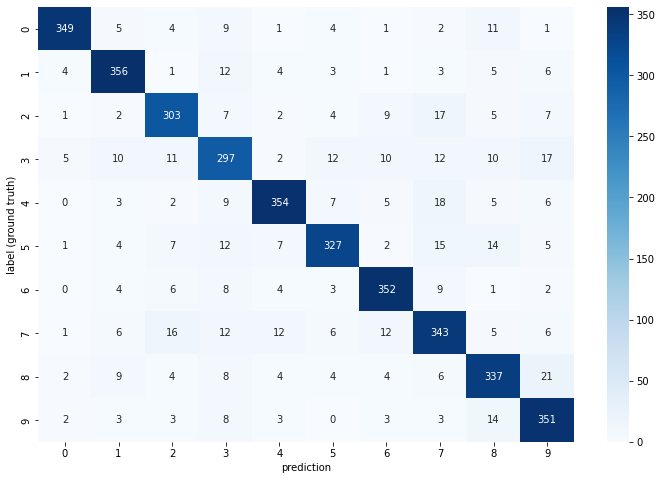

Acc of 0: 0.9018
Acc of 1: 0.9013
Acc of 2: 0.8487
Acc of 3: 0.7694
Acc of 4: 0.8655
Acc of 5: 0.8299
Acc of 6: 0.9049
Acc of 7: 0.8186
Acc of 8: 0.8446
Acc of 9: 0.9000

Total Acc: 0.858343949044586


In [ ]:
hm.test(test_dataloader, test_dataloader_f)

## VGG11

In [ ]:
vgg7 = VGG7(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg7.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1)

hm = HyperModule(
    model = vgg7,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

hm.load("/content/gdrive/MyDrive/Colab Checkpoints/VGG7/state_dict.ckpt")

State dict sucessfully loaded.


In [ ]:
class VGG11(VGG):
  def __init__(self, num_classes=10):
    super().__init__()
    self.conv_net = Sequential(
        Conv2d(3, 64, kernel_size=3, stride=1, padding=1),       ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(64, 128, kernel_size=3, stride=1, padding=1),     ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(128, 256, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(256, 256, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(256, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        Conv2d(512, 512, kernel_size=3, stride=1, padding=1),    ReLU(),
        MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc = Sequential(
        Flatten(),
        Linear(512*7*7, 4096),                                   ReLU(),
        Dropout(0.5), 
        Linear(4096, 4096),                                      ReLU(),
        Dropout(0.5),
        Linear(4096, num_classes)
    )
    self.converted_conv = Sequential(
        Conv2d(512, 4096, kernel_size=7, stride=1),              ReLU(),
        Conv2d(4096, 4096, kernel_size=1, stride=1),             ReLU(),
        Conv2d(4096, num_classes, kernel_size=1, stride=1),      Softmax(dim=1),
    )

    self.train_state = True
    self.net = self.build_net(self.train_state)

In [ ]:
vgg11 = VGG11()

# Copy Conv weights from VGG7 to VGG11
vgg11.conv_net[0].weight  = torch.nn.Parameter(vgg7.conv_net[0].weight)
vgg11.conv_net[0].bias    = torch.nn.Parameter(vgg7.conv_net[0].bias)
vgg11.conv_net[3].weight  = torch.nn.Parameter(vgg7.conv_net[3].weight)
vgg11.conv_net[3].bias    = torch.nn.Parameter(vgg7.conv_net[3].bias)
vgg11.conv_net[6].weight  = torch.nn.Parameter(vgg7.conv_net[6].weight)
vgg11.conv_net[6].bias    = torch.nn.Parameter(vgg7.conv_net[6].bias)
vgg11.conv_net[11].weight = torch.nn.Parameter(vgg7.conv_net[9].weight)
vgg11.conv_net[11].bias   = torch.nn.Parameter(vgg7.conv_net[9].bias)
vgg11.conv_net[16].weight = torch.nn.Parameter(vgg7.conv_net[12].weight)
vgg11.conv_net[16].bias   = torch.nn.Parameter(vgg7.conv_net[12].bias)

# Copy FC weights from VGG7 to VGG11
vgg11.fc[1].weight = torch.nn.Parameter(vgg7.fc[1].weight)
vgg11.fc[1].bias   = torch.nn.Parameter(vgg7.fc[1].bias)
vgg11.fc[7].weight = torch.nn.Parameter(vgg7.fc[3].weight)
vgg11.fc[7].bias   = torch.nn.Parameter(vgg7.fc[3].bias)

In [ ]:
BASE_LR = 0.01
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 50
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/VGG11/state_dict.ckpt"

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vgg11.parameters(), BASE_LR, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1)

hm = HyperModule(
    model = vgg11,
    criterion = criterion,
    optimizer = optimizer,
    scheduler = scheduler
)

hm.train(train_dataloader, (valid_dataloader, valid_dataloader_f), PATH, NUM_EPOCHS)

Epoch [1/50]: 100%|██████████| 237/237 [02:12<00:00,  1.79it/s, loss=2.29]


Train Loss: 2.306, Valid Acc:0.097
State dict saved.


Epoch [2/50]: 100%|██████████| 237/237 [01:59<00:00,  1.98it/s, loss=2.19]


Train Loss: 2.127, Valid Acc:0.313
State dict saved.


Epoch [3/50]: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s, loss=1.88]


Train Loss: 1.814, Valid Acc:0.409
State dict saved.


Epoch [4/50]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=1.51]


Train Loss: 1.529, Valid Acc:0.533
State dict saved.


Epoch [5/50]: 100%|██████████| 237/237 [01:59<00:00,  1.99it/s, loss=1.34]


Train Loss: 1.335, Valid Acc:0.635
State dict saved.


Epoch [6/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=1.56]


Train Loss: 1.232, Valid Acc:0.643
State dict saved.


Epoch [7/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.704]


Train Loss: 1.175, Valid Acc:0.648
State dict saved.


Epoch [8/50]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=1.05]


Train Loss: 1.022, Valid Acc:0.702
State dict saved.


Epoch [9/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=1.28]


Train Loss: 0.966, Valid Acc:0.680


Epoch [10/50]: 100%|██████████| 237/237 [01:55<00:00,  2.04it/s, loss=0.527]


Train Loss: 0.934, Valid Acc:0.699


Epoch [11/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.776]


Train Loss: 0.858, Valid Acc:0.711
State dict saved.


Epoch [12/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=1.09]


Train Loss: 0.857, Valid Acc:0.726
State dict saved.


Epoch [13/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=1.03]


Train Loss: 0.760, Valid Acc:0.745
State dict saved.


Epoch [14/50]: 100%|██████████| 237/237 [01:58<00:00,  1.99it/s, loss=0.629]


Train Loss: 0.765, Valid Acc:0.773
State dict saved.


Epoch [15/50]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=0.649]


Train Loss: 0.743, Valid Acc:0.781
State dict saved.


Epoch [16/50]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=0.567]


Train Loss: 0.694, Valid Acc:0.775


Epoch [17/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.337]


Train Loss: 0.679, Valid Acc:0.805
State dict saved.


Epoch [18/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.582]


Train Loss: 0.642, Valid Acc:0.773


Epoch [19/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.702]


Train Loss: 0.622, Valid Acc:0.756


Epoch [20/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.884]


Train Loss: 0.608, Valid Acc:0.806
State dict saved.


Epoch [21/50]: 100%|██████████| 237/237 [01:59<00:00,  1.99it/s, loss=0.327]


Train Loss: 0.587, Valid Acc:0.793


Epoch [22/50]: 100%|██████████| 237/237 [01:57<00:00,  2.03it/s, loss=0.789]


Train Loss: 0.563, Valid Acc:0.774


Epoch [23/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.768]


Train Loss: 0.547, Valid Acc:0.803


Epoch [24/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.702]


Train Loss: 0.519, Valid Acc:0.782


Epoch [25/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.207]


Train Loss: 0.519, Valid Acc:0.808
State dict saved.


Epoch [26/50]: 100%|██████████| 237/237 [01:59<00:00,  1.98it/s, loss=0.37]


Train Loss: 0.500, Valid Acc:0.805


Epoch [27/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.429]


Train Loss: 0.465, Valid Acc:0.835
State dict saved.


Epoch [28/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.261]


Train Loss: 0.476, Valid Acc:0.830


Epoch [29/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.6]


Train Loss: 0.454, Valid Acc:0.812


Epoch [30/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.523]


Train Loss: 0.424, Valid Acc:0.837
State dict saved.


Epoch [31/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.172]


Train Loss: 0.441, Valid Acc:0.842
State dict saved.


Epoch [32/50]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.179]


Train Loss: 0.397, Valid Acc:0.829


Epoch [33/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.382]


Train Loss: 0.443, Valid Acc:0.823


Epoch [34/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.425]


Train Loss: 0.423, Valid Acc:0.835


Epoch [35/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.339]


Train Loss: 0.387, Valid Acc:0.825


Epoch [36/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.436]


Train Loss: 0.379, Valid Acc:0.849
State dict saved.


Epoch [37/50]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=0.114]


Train Loss: 0.368, Valid Acc:0.844


Epoch [38/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.193]


Train Loss: 0.358, Valid Acc:0.823


Epoch [39/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.198]


Train Loss: 0.362, Valid Acc:0.847


Epoch [40/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.215]


Train Loss: 0.302, Valid Acc:0.848


Epoch [41/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.345]


Train Loss: 0.333, Valid Acc:0.818


Epoch [42/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.0891]


Train Loss: 0.300, Valid Acc:0.831


Epoch [43/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.21]


Train Loss: 0.323, Valid Acc:0.810


Epoch [44/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.43]


Train Loss: 0.317, Valid Acc:0.847


Epoch [45/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.618]


Train Loss: 0.306, Valid Acc:0.836


Epoch [46/50]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.516]


Train Loss: 0.309, Valid Acc:0.827


Epoch [47/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.337]


Train Loss: 0.291, Valid Acc:0.836


Epoch [48/50]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.215]


Train Loss: 0.171, Valid Acc:0.863
State dict saved.


Epoch [49/50]: 100%|██████████| 237/237 [01:58<00:00,  1.99it/s, loss=0.0968]


Train Loss: 0.136, Valid Acc:0.861


Epoch [50/50]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.078]


Train Loss: 0.121, Valid Acc:0.870
State dict saved.
State dict saved.


In [ ]:
BASE_LR = 0.001
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
NUM_EPOCHS = 30
PATH = "/content/gdrive/MyDrive/Colab Checkpoints/VGG11/state_dict2.ckpt"

In [ ]:
optimizer = torch.optim.SGD(hm.model.parameters(), 0.001, MOMENTUM, 0, WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', factor=0.1)

hm.optimizer = optimizer
hm.scheduler = scheduler
hm.train(train_dataloader, (valid_dataloader, valid_dataloader_f), PATH, NUM_EPOCHS)

Epoch [51/80]: 100%|██████████| 237/237 [02:03<00:00,  1.92it/s, loss=0.0435]


Train Loss: 0.114, Valid Acc:0.868


Epoch [52/80]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.051]


Train Loss: 0.115, Valid Acc:0.869


Epoch [53/80]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.194]


Train Loss: 0.103, Valid Acc:0.867


Epoch [54/80]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.0176]


Train Loss: 0.098, Valid Acc:0.866


Epoch [55/80]: 100%|██████████| 237/237 [01:58<00:00,  2.01it/s, loss=0.0627]


Train Loss: 0.098, Valid Acc:0.869


Epoch [56/80]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=0.0461]


Train Loss: 0.088, Valid Acc:0.874
State dict saved.


Epoch [57/80]: 100%|██████████| 237/237 [02:02<00:00,  1.93it/s, loss=0.041]


Train Loss: 0.091, Valid Acc:0.872


Epoch [58/80]: 100%|██████████| 237/237 [01:59<00:00,  1.98it/s, loss=0.113]


Train Loss: 0.088, Valid Acc:0.874


Epoch [59/80]: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s, loss=0.148]


Train Loss: 0.089, Valid Acc:0.871


Epoch [60/80]: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s, loss=0.0274]


Train Loss: 0.081, Valid Acc:0.868


Epoch [61/80]: 100%|██████████| 237/237 [01:59<00:00,  1.99it/s, loss=0.0438]


Train Loss: 0.076, Valid Acc:0.874


Epoch [62/80]: 100%|██████████| 237/237 [02:00<00:00,  1.97it/s, loss=0.0581]


Train Loss: 0.077, Valid Acc:0.870


Epoch [63/80]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.13]


Train Loss: 0.073, Valid Acc:0.868


Epoch [64/80]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.109]


Train Loss: 0.068, Valid Acc:0.877
State dict saved.


Epoch [65/80]: 100%|██████████| 237/237 [02:00<00:00,  1.96it/s, loss=0.0299]


Train Loss: 0.072, Valid Acc:0.876


Epoch [66/80]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.0188]


Train Loss: 0.065, Valid Acc:0.879
State dict saved.


Epoch [67/80]: 100%|██████████| 237/237 [01:58<00:00,  1.99it/s, loss=0.00631]


Train Loss: 0.067, Valid Acc:0.874


Epoch [68/80]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.00374]


Train Loss: 0.066, Valid Acc:0.875


Epoch [69/80]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.0184]


Train Loss: 0.063, Valid Acc:0.873


Epoch [70/80]: 100%|██████████| 237/237 [01:58<00:00,  2.00it/s, loss=0.00245]


Train Loss: 0.061, Valid Acc:0.877


Epoch [71/80]: 100%|██████████| 237/237 [01:57<00:00,  2.01it/s, loss=0.057]


Train Loss: 0.058, Valid Acc:0.874


Epoch [72/80]: 100%|██████████| 237/237 [01:58<00:00,  2.01it/s, loss=0.00533]


Train Loss: 0.060, Valid Acc:0.875


Epoch [73/80]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.00825]


Train Loss: 0.054, Valid Acc:0.875


Epoch [74/80]: 100%|██████████| 237/237 [01:57<00:00,  2.02it/s, loss=0.0257]


Train Loss: 0.051, Valid Acc:0.872


Epoch [75/80]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.00471]


Train Loss: 0.054, Valid Acc:0.875


Epoch [76/80]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.0257]


Train Loss: 0.052, Valid Acc:0.868


Epoch [77/80]: 100%|██████████| 237/237 [01:56<00:00,  2.03it/s, loss=0.145]


Train Loss: 0.050, Valid Acc:0.872


Epoch [78/80]: 100%|██████████| 237/237 [01:57<00:00,  2.03it/s, loss=0.123]


Train Loss: 0.050, Valid Acc:0.878


Epoch [79/80]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.018]


Train Loss: 0.046, Valid Acc:0.878


Epoch [80/80]: 100%|██████████| 237/237 [01:56<00:00,  2.04it/s, loss=0.115]


Train Loss: 0.047, Valid Acc:0.878
State dict saved.


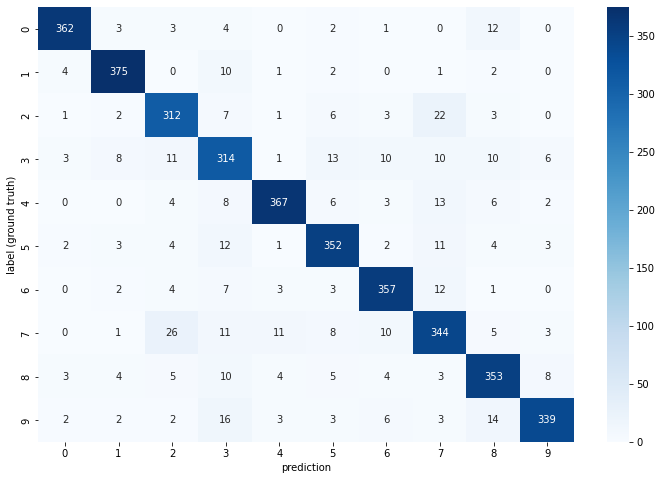

Acc of 0: 0.9354
Acc of 1: 0.9494
Acc of 2: 0.8739
Acc of 3: 0.8135
Acc of 4: 0.8973
Acc of 5: 0.8934
Acc of 6: 0.9177
Acc of 7: 0.8210
Acc of 8: 0.8847
Acc of 9: 0.8692

Total Acc: 0.8853503184713376


In [ ]:
hm.test(test_dataloader, test_dataloader_f)

# Delete Machine after finishing


In [ ]:
from google.colab import runtime
runtime.unassign()

Reference:
* [Network In Network](https://arxiv.org/pdf/1312.4400.pdf)
* [Dive into Deep Learning - Section 8.3](http://d2l.ai/chapter_convolutional-modern/nin.html)
* [Blog Post from 星期五。見面](https://meetonfriday.com/posts/a151bfa2/)
* [Blog Post from Math.py](https://allen108108.github.io/blog/2019/10/07/%5B%E8%AB%96%E6%96%87%5D%20Network%20In%20Network/)